In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import json
from grade_rank_calculation import calculate_grade_rank
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.offline as offline
from geopy.geocoders import Nominatim
import matplotlib.lines as mlines

In [19]:
# (1) read data

df = pd.read_pickle('CuratedWithRatings_OpenBetaAug2020_RytherAnderson.pkl.zip', compression='zip')
df = df.where(pd.notnull(df), None)

# splite user_ratings into two columns for ease of use
df['users'] = df.apply(lambda row: [r[0] for r in row['corrected_users_ratings']], axis = 1)
df['ratings'] = df.apply(lambda row: [r[1] for r in row['corrected_users_ratings']], axis = 1)

In [20]:
# (2) new variables, list comprehension is much faster than apply

def intMedian(ratings):
    
    if len(ratings) == 0:
        return None
    
    M = float(np.median(ratings))
    
    nl = len([n for n in ratings if n < M])
    ne = len([n for n in ratings if n == M])
    ng = len([n for n in ratings if n > M])
    
    if ne == 0:
        return M
    else:
        return M + ((ng-nl)/(2.0*ne))
        
df['mean_rating'] = [np.mean(r) for r in df.ratings.values]
df['median_rating'] = [intMedian(r) for r in df.ratings.values]
df['mode_rating'] = [stats.mode(r)[0][0] for r in df.ratings.values]
df['num_votes'] = [len(r) for r in df.ratings.values]

df['RQI_mean'] = df['mean_rating'] * (1.0 - (1.0/df['num_votes']))
df['RQI_median'] = df['median_rating'] * (1.0 - (1.0/df['num_votes']))

In [21]:
# (3) make subsets and calculate new categorization variables
# There are not many boulders in the dataset with user ratings (234), so boulders are not used in this analysis.
# Mixed routes are lumped into a new category with trad (trad_mixed = routes that take gear).
# Seven sport climbs are only given V grades, these are removed.

df = df[df['type_string'] != 'boulder']
df = df[df['YDS_rank'].notnull()]
df.loc[df['type_string'] == 'mixed', 'type_string'] = 'trad'
df['YDS_rank'] = df['YDS_rank'].astype(int)
df['VCID'] = df['YDS_rank'].astype(str) + df['type_string'] # vote count ID

sport = df[df['type_string'] == 'sport'].copy()
trad_mixed = df[df['type_string'] == 'trad'].copy()

total = len(df.index)
print(total, 'total climbs after removing boulders')

96722 total climbs after removing boulders


In [22]:
# (3) adjusted RQI, meant to account for harder routes seeing fewer ascents.
# Essentially, votes are weighted more for harder routes. The weights are calculated from the distribution of mean vote counts.
# Weights are calculated separately for sport and trad, since these types have different mean vote count distributions.

SC = sport.groupby('VCID', as_index=False).agg({'num_votes': ['sum', 'count']})
TC = trad_mixed.groupby('VCID', as_index=False).agg({'num_votes': ['sum', 'count']})

SC['VPR'] = SC[('num_votes','sum')]/SC[('num_votes','count')]
TC['VPR'] = TC[('num_votes','sum')]/TC[('num_votes','count')]

SC['VCAF'] = 1.0/(SC['VPR']/max(SC['VPR'])) # VCAF = vote count adjustment factor
TC['VCAF'] = 1.0/(TC['VPR']/max(TC['VPR']))

SC = SC.drop('num_votes', 1)
TC = TC.drop('num_votes', 1)

VC = pd.concat([SC, TC])
VC.columns = [''.join(col) if type(col) is tuple else col for col in SC.columns.values]
df = pd.merge(df, VC, on='VCID')

df['adjusted_num_votes'] = df['num_votes'] * df['VCAF']
df['ARQI_mean'] = df['mean_rating'] * (1.0 - (1.0/df['adjusted_num_votes']))
df['ARQI_median'] = df['median_rating'] * (1.0 - (1.0/df['adjusted_num_votes']))

/Users/Ryther/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [23]:
# (4) assessing different metrics for finding "the best routes"

df_quality = df[['route_name', 'route_ID', 'type_string', 'num_votes', 
                 'adjusted_num_votes', 'mean_rating', 'median_rating', 'mode_rating',
                 'RQI_mean', 'RQI_median', 'ARQI_mean', 'ARQI_median', 'nopm_YDS', 'YDS_rank']].copy()

def find_best_routes(df, metrics, num=3, route_type='all', grade_range='all'):
    
    if route_type != 'all':
        df = df[df['type_string'] == route_type].copy()
    
    if grade_range != 'all':
        lo,hi = grade_range
        lo_rank = calculate_grade_rank(lo)
        hi_rank = calculate_grade_rank(hi)                
        df = df[(lo_rank <= df['YDS_rank']) & (df['YDS_rank'] <= hi_rank)].copy()
    
    rankings = []
    for metric in metrics:
        rank_name =  '_'.join([metric, 'rank'])
        df[rank_name] = df[metric].rank(method='dense', ascending=False)
        rankings.append(rank_name)
    
    df['total_rank'] = 0
    for rank in rankings:
        df['total_rank'] += df[rank]
    df['average_rank'] = df['total_rank']/len(rankings)
    
    df = df.sort_values(by=['average_rank'])
    routes = df.head(num)
    
    return routes
    
find_best_routes(df_quality, ['ARQI_median'], num=10, grade_range=('5.10a','5.11a'), route_type='sport')

,route_name,route_ID,type_string,num_votes,adjusted_num_votes,mean_rating,median_rating,mode_rating,RQI_mean,RQI_median,ARQI_mean,ARQI_median,nopm_YDS,YDS_rank,ARQI_median_rank,total_rank,average_rank
42718,Gracious Grant,110489523,sport,54,91.487492,3.962963,3.980769,4.0,3.889575,3.907051,3.919646,3.937258,5.10d,106,1.0,1.0,1.0
45135,Dead Dog,106654497,sport,67,107.222380,3.940299,3.968254,4.0,3.881488,3.909026,3.903550,3.931244,5.11a,110,2.0,2.0,2.0
45505,Legacy,106282216,sport,309,494.503215,3.880259,3.938182,4.0,3.867701,3.925437,3.872412,3.930218,5.11a,110,3.0,3.0,3.0
43658,Wild at Heart,106447069,sport,109,174.436409,3.862385,3.943878,4.0,3.826951,3.907695,3.840243,3.921268,5.11a,110,4.0,4.0,4.0
46009,Escapade,105881218,sport,37,59.212359,3.945946,3.971429,4.0,3.839299,3.864093,3.879305,3.904358,5.11a,110,5.0,5.0,5.0
45265,Spaceballs,105872778,sport,26,41.608685,4.000000,4.000000,4.0,3.846154,3.846154,3.903866,3.903866,5.11a,110,6.0,6.0,6.0
45880,Made In Japan,105735761,sport,72,115.224050,3.861111,3.928571,4.0,3.807485,3.874008,3.827602,3.894476,5.11a,110,7.0,7.0,7.0
43489,Moons of Pluto,105803003,sport,351,594.668700,3.809117,3.894828,4.0,3.798265,3.883731,3.802711,3.888278,5.10d,106,8.0,8.0,8.0
45970,O.R.G.asam,105880789,sport,129,206.443090,3.829457,3.902778,4.0,3.799772,3.872524,3.810908,3.883873,5.11a,110,9.0,9.0,9.0
31512,Carp,105876102,sport,59,83.684379,3.864407,3.921569,4.0,3.798908,3.855101,3.818228,3.874707,5.10c,104,10.0,10.0,10.0


In [28]:
df_save = df[['route_name', 'route_ID', 'type_string', 'sector_ID', 'parent_sector', 'parent_loc', 'num_votes', 
              'adjusted_num_votes', 'mean_rating', 'median_rating', 'mode_rating', 'RQI_mean', 
              'RQI_median', 'ARQI_mean', 'ARQI_median', 'nopm_YDS', 'YDS_rank', 'safety']].copy()

SA = pd.read_pickle('Sector_Addresses.pkl.zip')
SA['state'] = [d.get('state') for d in SA.sector_address]
states = SA[['sector_ID', 'state']]
df_save = pd.merge(df_save, states, on='sector_ID')

df_save.to_pickle('RouteQualityData.pkl.zip', compression='zip')

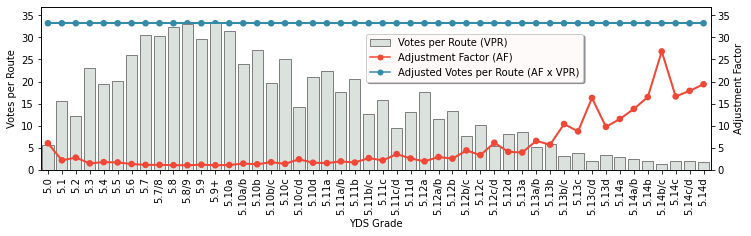

In [25]:
YDS_grade_order = ['5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.7/8', '5.8', '5.8/9', '5.9', '5.9+', '5.10a', 
                   '5.10a/b', '5.10b', '5.10b/c', '5.10c', '5.10c/d', '5.10d', '5.11a', '5.11a/b', '5.11b', '5.11b/c', 
                   '5.11c', '5.11c/d', '5.11d', '5.12a', '5.12a/b', '5.12b', '5.12b/c', '5.12c', '5.12c/d', '5.12d', '5.13a', 
                   '5.13a/b', '5.13b', '5.13b/c', '5.13c', '5.13c/d', '5.13d', '5.14a', '5.14a/b', '5.14b', '5.14b/c', '5.14c', 
                   '5.14c/d', '5.14d', '5.15a', '5.15c/d']

SCplot = sport.groupby('nopm_YDS', as_index=False).agg({'num_votes': ['sum', 'count']})
SCplot['VPR'] = SCplot[('num_votes','sum')]/SCplot[('num_votes','count')]
SCplot['fac'] = 1.0/(SCplot['VPR']/max(SCplot['VPR']))
SCplot['AVPR'] = SCplot['fac'] * SCplot['VPR']

fig, ax0 = plt.subplots(figsize=(12,3))
ax0 = sns.barplot(data=SCplot, x='nopm_YDS', y='VPR', color='#DAE3DE',
                 order=YDS_grade_order[0:-2], edgecolor='grey', label='Votes per Route (VPR)')
ax1 = ax0.twinx()
sns.pointplot(data=SCplot, x='nopm_YDS', y='fac', ax=ax1, color='#F04737',
              order=YDS_grade_order[0:-2], kind='point', scale=0.75)

sns.pointplot(data=SCplot, x='nopm_YDS', y='AVPR', ax=ax0, color='#338BA8',
              order=YDS_grade_order[0:-2], kind='line', scale=0.75)

lines0, labels0 = ax0.get_legend_handles_labels()

lines1 = [mlines.Line2D([], [], color='#F04737', marker='o', markersize=5)]
linesa = [mlines.Line2D([], [], color='#338BA8', marker='o', markersize=5)]

labels1 = ['Adjustment Factor (AF)']
labelsa = ['Adjusted Votes per Route (AF x VPR)']

lines = lines0 + lines1 + linesa
labels = labels0 + labels1 + labelsa

ax0.legend(lines, labels, loc=(0.485,0.54), shadow=True, facecolor='snow')

ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90, horizontalalignment='center')
ax0.set(xlabel='YDS Grade', ylabel='Votes per Route')

ax0.set_ylim(0,37)
ax1.set_ylim(0,37)

ax1.set(ylabel='Adjustment Factor')
plt.savefig('plots/sport_votes_per_route.png', bbox_inches='tight', dpi=300)
